# Cluster the data and visualize
Following [this guide](https://www.askpython.com/python/examples/plot-k-means-clusters-python)

In [1]:
!pip install sklearn matplotlib mplcursors ipympl

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
N_CLUSTERS = 10

In [3]:
#Importing required modules
from typing import List, Tuple
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import json

embeddings: List[Tuple[str, List[float]]] = json.load(open('data_store/embeddings.json'))
 
#Load Data
# data = load_digits().data
data = np.array([e[1] for e in embeddings])
pca = PCA(2)
 
#Transform the data
df = pca.fit_transform(data)
 
#Import KMeans module
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters= N_CLUSTERS)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df)
 
#Getting unique labels
u_labels = np.unique(label)

/home/lev/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


19

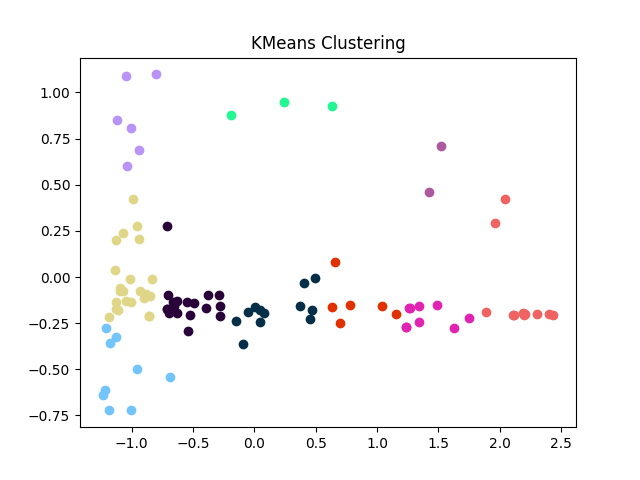

AttributeError: 'NoneType' object has no attribute 'canvas'

AttributeError: 'NoneType' object has no attribute 'canvas'

In [32]:
%matplotlib ipympl
from mplcursors import cursor
import mplcursors
from matplotlib.text import Annotation

# fig, ax = plt.subplots()

# for i in range(len(df)):
# 		np.random.seed(label[i])
# 		ax.scatter(df[i , 0] , df[i , 1] , label = f"Cluster {i}", color = np.random.rand(3,))
colors = np.random.rand(N_CLUSTERS, 3)
scs = []
# for i in range (len(df[:100])):
fig, ax = plt.subplots()
for i in np.random.choice(np.arange(len(df)), size=100):
    sc = ax.scatter(df[i, 0], df[i, 1], label=embeddings[i][0], color=colors[label[i]])
    scs.append(sc)

ax.set_title("KMeans Clustering")
crs = mplcursors.cursor(ax,hover=True)

crs.connect("add", lambda sel: sel.annotation.set_text(sel.annotation._text))#embeddings[sel.index][0]))#, sel.target[0], sel.target[1])))
# plt.show()
# for l in label:
#     mask = label == l
#     sc = ax.scatter(df[mask, 0], df[mask, 1], label=f"Cluster {l}", color=np.random.rand(3,))
#     scs.append(sc)
def on_plot_hover(event):
    # Iterating over each data member plotted
    return 
    for curve in sc.get_lines():
        # Searching which data member corresponds to current mouse position
        if curve.contains(event)[0]:
            print("over %s" % curve.get_gid())
            
fig.canvas.mpl_connect('motion_notify_event', on_plot_hover)           
